# Sidewalk Safe Navigation

`pyspect` can set up problems independently from implementations...
At this stage, we only need to import pyspect and select a pyspect language...

In [1]:
from math import pi

from pyspect import *
from pyspect.langs.ltl import *

TLT.select(ContinuousLTL)

## Implementation

Implementation using `hj_reachability`.

In [2]:
import numpy as np
import hj_reachability as hj

class HJImpl(ContinuousLTL.Impl):

    solver_settings = hj.SolverSettings.with_accuracy("low")

    def __init__(self, dynamics, grid, time_horizon):
        self.grid = grid
        self.ndim = grid.ndim
        self.dynamics = dynamics
        self.timeline = self.new_timeline(time_horizon)
           
    def new_timeline(self, target_time, start_time=0, time_step=0.2):
        assert time_step > 0
        is_forward = target_time >= start_time
        target_time += 1e-5 if is_forward else -1e-5
        time_step *= 1 if is_forward else -1
        return np.arange(start_time, target_time, time_step)

    def set_axes_names(self, *args):
        assert len(args) == self.ndim
        self._axes_names = tuple(args)

    def axis(self, name: str) -> int:
        assert name in self._axes_names, f'Axis ({name=}) does not exist.'
        return self._axes_names.index(name)

    def axis_name(self, i: int) -> str:
        assert i < len(self._axes_names), f'Axis ({i=}) does not exist.'
        return self._axes_names[i]

    def axis_is_periodic(self, i: int) -> bool:
        assert i < len(self._axes_names), f'Axis ({i=}) does not exist.'
        return bool(self.grid._is_periodic_dim[i])

    def plane_cut(self, normal, offset, axes=None):
        data = np.zeros(self.grid.shape)
        axes = axes or list(range(self.grid.ndim))
        x = lambda i: self.grid.states[..., i]
        for i, k, m in zip(axes, normal, offset):
            data -= k*x(i) - k*m
        return data

    def empty(self):
        return np.ones(self.grid.shape)*np.inf
    
    def complement(self, vf):
        return np.asarray(-vf)
    
    def intersect(self, vf1, vf2):
        return np.maximum(vf1, vf2)

    def union(self, vf1, vf2):
        return np.minimum(vf1, vf2)
    
    def reach(self, target, constraints=None):
        self.dynamics.with_mode('reach')
        if not self.is_invariant(target):
            target = np.flip(target, axis=0)
        if not self.is_invariant(constraints):
            constraints = np.flip(constraints, axis=0)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      target,
                      constraints)
        return np.flip(np.asarray(vf), axis=0)
    
    def avoid(self, target, constraints=None):
        self.dynamics.with_mode('avoid')
        if not self.is_invariant(target):
            target = np.flip(target, axis=0)
        if not self.is_invariant(constraints):
            constraints = np.flip(constraints, axis=0)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      -self.timeline,
                      target,
                      constraints)
        return np.flip(np.asarray(vf), axis=0)

    def project_onto(self, vf, *idxs, keepdims=False, union=True):
        idxs = [len(vf.shape) + i if i < 0 else i for i in idxs]
        dims = [i for i in range(len(vf.shape)) if i not in idxs]
        if union:
            return vf.min(axis=tuple(dims), keepdims=keepdims)
        else:
            return vf.max(axis=tuple(dims), keepdims=keepdims)

    def is_invariant(self, vf):
        return (True if vf is None else
                len(vf.shape) != len(self.timeline.shape + self.grid.shape))

    def make_tube(self, vf):
        return (vf if not self.is_invariant(vf) else
                np.concatenate([vf[np.newaxis, ...]] * len(self.timeline)))

## Environment

Setting up the sidewalk environment...

In [3]:
## CONSTANTS ##

# Define origin and size of area, makes it easier to scale up/down later on 
X0, XN = 0.0, 10.0
Y0, YN = -2.5, 2.5

# Occupancy grid parameters
MAP_PATH = 'sidewalk_map.pgm'
MAP_RES = 0.05
MAP_ORIGIN = (0.0, -5.0)
BACKGROUND_PATH = 'sidewalk_map.png'

# Function to generate background image
def generate_background_image(map_path, bg_path, bounds, res, origin):
    from PIL import Image
    import matplotlib.pyplot as plt
    
    # Load map
    map_arr = np.array(Image.open(map_path).convert('L'))
    # Crop map to desired bounds
    x0 = max(0, int((bounds[0] - origin[0]) / res))
    xn = min(map_arr.shape[1], int((bounds[1] - origin[0]) / res))
    y0 = max(0, int((bounds[2] - origin[1]) / res))
    yn = min(map_arr.shape[0], int((bounds[3] - origin[1]) / res))
    map_arr = map_arr[y0:yn, x0:xn]
    # Save cropped map
    plt.imsave(bg_path, map_arr, cmap='gray')
    
generate_background_image(MAP_PATH, BACKGROUND_PATH, (X0, XN, Y0, YN), MAP_RES, MAP_ORIGIN)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


dx = 0.099999994 dy = 0.099999994 da = 0.20268339 dv = 0.1


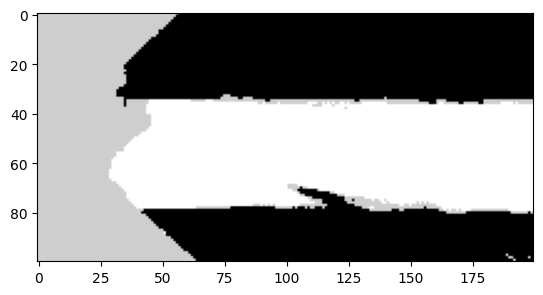

In [4]:
## GRID ##
from hj_reachability.systems import Bicycle4D
from hj_reachability.plotting import *
from PIL import Image


reach_dynamics = Bicycle4D(min_steer=-5*np.pi/4, 
                           max_steer=+5*np.pi/4,
                           min_accel=-0.4,
                           max_accel=+0.4)

min_bounds = np.array([X0, Y0, -np.pi, +0.0])
max_bounds = np.array([XN, YN, +np.pi, +1.0])
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds, max_bounds),
                                                               (101, 51, 31, 11),
                                                               periodic_dims=2)

X, Y, A, V = range(grid.ndim)

print('dx =', grid.spacings[0], 
      'dy =', grid.spacings[1],
      'da =', grid.spacings[2],
      'dv =', grid.spacings[3])

plt.imshow(plt.imread(BACKGROUND_PATH))
plt.show()

In [5]:
import hj_reachability.shapes as shp
from scipy.signal import correlate2d
from PIL import Image
from scipy.ndimage import distance_transform_edt

def load_vf_from_map(grid, map_path, map_res, map_origin, XY_dims=(0, 1)):
    """
    Load XY value function from an occupancy grid map.
    """            
    # Load the occupancy grid map
    map_img = Image.open(map_path)
    map_data = np.fliplr(np.array(map_img).T)
    map_data = np.where(map_data < 250, 1, -1)
    
    # Initialize the value function
    xy_vf = np.zeros([grid.shape[i] for i in XY_dims])
    num_outside_map = 0
    
    # Fill the value function with the occupancy grid map
    # Create a meshgrid of the grid coordinates
    x_coords, y_coords = np.meshgrid(grid.coordinate_vectors[XY_dims[0]], grid.coordinate_vectors[XY_dims[1]], indexing='ij')
    
    # Convert grid coordinates to map coordinates
    i_map_coords = ((x_coords - map_origin[0]) / map_res).astype(int)
    j_map_coords = ((y_coords - map_origin[1]) / map_res).astype(int)
    
    # Check which coordinates are inside the map
    inside_map_mask = (i_map_coords >= 0) & (i_map_coords < map_data.shape[0]) & (j_map_coords >= 0) & (j_map_coords < map_data.shape[1])
    
    # Fill the value function with the occupancy grid map
    xy_vf[inside_map_mask] = map_data[i_map_coords[inside_map_mask], j_map_coords[inside_map_mask]]
    
    # Count the number of points outside the map
    num_outside_map = np.sum(~inside_map_mask)
                
    if num_outside_map > 0:
        print(f'Warning: {num_outside_map} points are outside the map.')
                
    # Return the correct shape of the value function 
    slices = [np.newaxis] * grid.ndim
    slices[XY_dims[0]] = slice(None)
    slices[XY_dims[1]] = slice(None)
    xy_vf = np.ones(grid.shape) * xy_vf[tuple(slices)]
    return xy_vf

def get_robot_projections(robot_footprint, grid):
    """
    Get the robot projections as a 2D array of (0, 1) values where 1 represents the robot's projection.
    """
    # Assert that the robot footprint is rectangular
    assert len(robot_footprint) == 4, 'Robot footprint must be a rectangle, given as a list of 4 values representing the distances from the origin to the sides of the rectangle in the order [front, left, rear, right].'
    # Get values from the grid
    min_spacing = np.min(grid.spacings[:2])
    theta_values = grid.coordinate_vectors[2]
    num_projections = grid.shape[2]
    # Calculate all corner points of the robot footprint
    corner_points_indices = np.array([[0, 1], [0, 3], [2, 1], [2, 3]])
    corner_points = robot_footprint[corner_points_indices]
    # Calculate the distance from the origin to the corner points
    distances = np.linalg.norm(corner_points, axis=1)
    # Calculate the maximum distance from the origin to the corner points
    max_distance = np.max(distances)
    # Calculate the number of points in the robot projection
    num_points = int(np.ceil(max_distance / min_spacing))
    # Initialize the robot projection
    robot_projections = np.zeros((2*num_points+1, 2*num_points+1, num_projections))
    # Generate the grid for the robot projection
    min_bounds = np.array([-num_points*grid.spacings[0], -num_points*grid.spacings[1]])
    max_bounds = np.array([num_points*grid.spacings[0], num_points*grid.spacings[1]])
    robot_projection_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds, max_bounds), (robot_projections.shape[0], robot_projections.shape[1]))
    # Calculate the robot projection using half-plane surfaces
    for i in range(num_projections):
        theta = theta_values[i]
        robot_projection_front = shp.hyperplane(robot_projection_grid, normal=[np.cos(theta), np.sin(theta)], offset=[robot_footprint[0]*np.cos(theta), robot_footprint[0]*np.sin(theta)])
        robot_projection_left = shp.hyperplane(robot_projection_grid, normal=[np.cos(theta + np.pi/2), np.sin(theta + np.pi/2)], offset=[robot_footprint[1]*np.cos(theta + np.pi/2), robot_footprint[1]*np.sin(theta + np.pi/2)])
        robot_projection_rear = shp.hyperplane(robot_projection_grid, normal=[np.cos(theta + np.pi), np.sin(theta + np.pi)], offset=[robot_footprint[2]*np.cos(theta + np.pi), robot_footprint[2]*np.sin(theta + np.pi)])
        robot_projection_right = shp.hyperplane(robot_projection_grid, normal=[np.cos(theta - np.pi/2), np.sin(theta - np.pi/2)], offset=[robot_footprint[3]*np.cos(theta - np.pi/2), robot_footprint[3]*np.sin(theta - np.pi/2)])
        robot_projection = shp.intersection(robot_projection_front, robot_projection_left, robot_projection_rear, robot_projection_right)
        robot_projections[:, :, i] = np.where(robot_projection <= 0, 1, 0)
    return robot_projections

def inflate_vf_xy(vf, robot_projections):
    """
    Inflate the XY occupancy of a vf by the robot projection using cross-correlation and distance to the nearest boundary. The robot projection is a 3D grid of (0, 1) values for each angle, where 1 represents the robot's projection on the grid.
    """
    # Assert the robot projection is a 3D grid
    assert len(robot_projections.shape) == 3, 'Robot projection must be a 3D grid.'
    
    # Inflate the grid by robot projection using cross-correlation
    print('Inflating the grid by robot projection...')
    xy_grid = np.where(vf[:,:,0,0] <= 0, 0, 1)
    xya_inflated_grid = np.zeros(vf.shape[:3])
    for i in range(vf.shape[2]):
        robot_projection = robot_projections[:, :, i]
        inflation = correlate2d(xy_grid, robot_projection, mode='same', boundary='fill', fillvalue=1)
        xya_inflated_grid[:,:,i] = np.where(inflation <= 0, 0, 1)
    
    # Calculate the inflated vf using the distance to the nearest boundary using Euclidean distance transform
    print('Calculating the inflated vf...')
    xya_inflated_vf_unoccupied = distance_transform_edt(xya_inflated_grid, sampling=grid.spacings[:3])
    xya_inflated_vf_occupied = distance_transform_edt(1 - xya_inflated_grid, sampling=grid.spacings[:3])
    xya_inflated_vf = xya_inflated_vf_unoccupied - xya_inflated_vf_occupied
    
    # Return the inflated vf    
    slices = (...,) + (np.newaxis,) * (vf.ndim - xya_inflated_vf.ndim)
    inflated_vf = np.ones(vf.shape) * xya_inflated_vf[slices]
    return inflated_vf

In [6]:
import time

# Start the timer
start = time.time()

# Creating the sidewalk geometries
print('Creating the sidewalk geometries...')
sidewalk_vf = shp.intersection(shp.hyperplane(grid, normal=[0,  1], offset=[0, 1.15]),
                               shp.hyperplane(grid, normal=[0, -1], offset=[0, -1.15]))
sidewalk_map_vf = load_vf_from_map(grid, MAP_PATH, MAP_RES, MAP_ORIGIN)

time_geometries = time.time()

# Inflate the sidewalk set by the robot projection
print('Inflating the sidewalk set by the robot projection...')
ROBOT_FOOTPRINT = np.array([0.4,0.15,0.15,0.15])
robot_projections = get_robot_projections(ROBOT_FOOTPRINT, grid)

time_projections = time.time()

sidewalk_inflated_vf = inflate_vf_xy(sidewalk_vf, robot_projections)
sidewalk_map_inflated_vf = inflate_vf_xy(sidewalk_map_vf, robot_projections)

time_inflation = time.time()

# Wrap into sets
sidewalk = Set(sidewalk_vf)
sidewalk_map = Set(sidewalk_map_vf)
sidewalk_inflated = Set(sidewalk_inflated_vf)
sidewalk_map_inflated = Set(sidewalk_map_inflated_vf)

# Alt set
sidewalk_alt = And(HalfSpaceSet(normal=[0, -1], offset=[0, 1.15]),
                   HalfSpaceSet(normal=[0, 1], offset=[0, -1.15]))

time_sets = time.time()

# Logging
print(f'Sidewalk environment created. Time elapsed for geometries: {time_geometries-start:.2f}s, projections: {time_projections-time_geometries:.2f}s, inflation: {time_inflation-time_projections:.2f}s, sets: {time_sets-time_inflation:.2f}s, total: {time_sets-start:.2f}s')

Creating the sidewalk geometries...
Inflating the sidewalk set by the robot projection...
Inflating the grid by robot projection...
Calculating the inflated vf...
Inflating the grid by robot projection...
Calculating the inflated vf...
Sidewalk environment created. Time elapsed for geometries: 0.10s, projections: 0.21s, inflation: 0.12s, sets: 0.00s, total: 0.43s


# Visualization of the sidewalk environment

In [7]:
# Heading in degrees with respect to the x-axis (0 is right, 90 is up)
heading = 45
# Get grid index for the heading
a_idx = int((heading*np.pi/180 - min_bounds[2]) / grid.spacings[2]) 

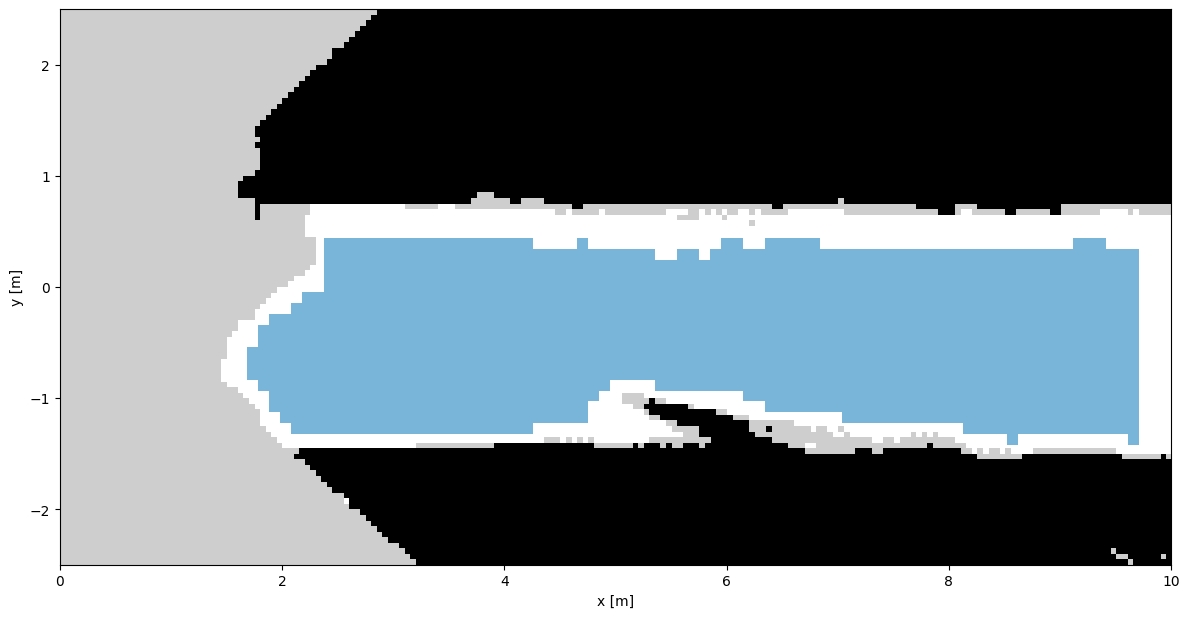

In [8]:
impl = HJImpl(reach_dynamics, grid, 1)
impl.set_axes_names('x', 'y', 'a', 'v')
fig = new_map(
              ('Blues', sidewalk_map_inflated_vf[:,:,a_idx,0]),
              min_bounds=min_bounds, max_bounds=max_bounds,
              background=BACKGROUND_PATH,
            )

# Realization

Sidewalk environment realization...

100%|##########|  1.0000/1.0 [00:05<00:00,  5.03s/sim_s]
/tmp/ipykernel_23131/4044821904.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


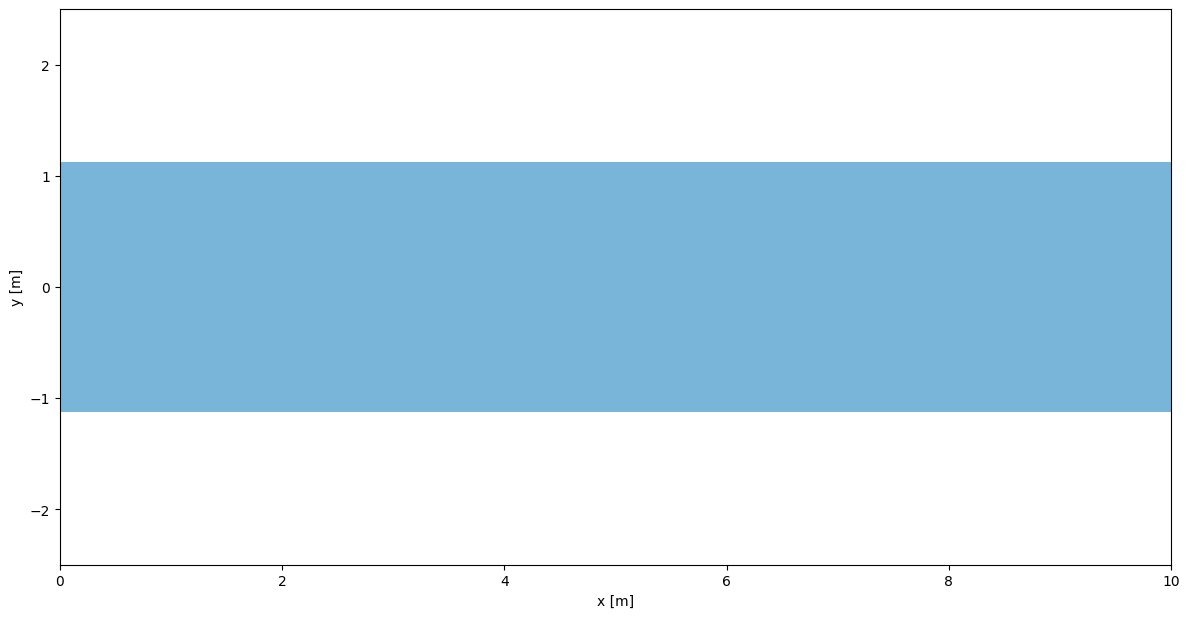

In [9]:
impl = HJImpl(reach_dynamics, grid, 1)
impl.set_axes_names('x', 'y', 'a', 'v')

out = Always(sidewalk).realize(impl)

fig = new_map(
    ('Blues', impl.project_onto(out[0], 0, 1, union=True)),
    min_bounds=min_bounds, max_bounds=max_bounds,
)
fig.show()

Sidewalk alt (using HalfSpaceSet) environment realization...

100%|##########|  1.0000/1.0 [00:04<00:00,  4.24s/sim_s]
/tmp/ipykernel_23131/2021338523.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


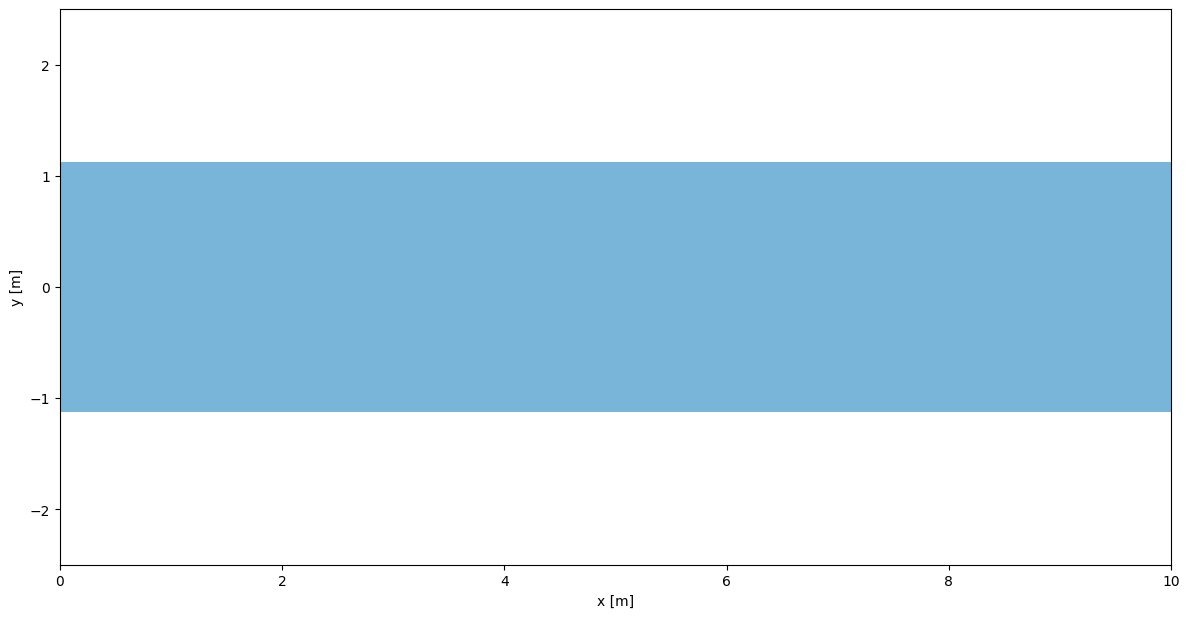

In [10]:
impl = HJImpl(reach_dynamics, grid, 1)
impl.set_axes_names('x', 'y', 'a', 'v')

out_alt = Always(sidewalk_alt).realize(impl)

fig = new_map(
    ('Blues', impl.project_onto(out_alt[0], 0, 1, union=True)),
    min_bounds=min_bounds, max_bounds=max_bounds,
)
fig.show()

Sidewalk map environment realization...

100%|##########|  1.0000/1.0 [00:04<00:00,  4.11s/sim_s]
/tmp/ipykernel_23131/3443014001.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


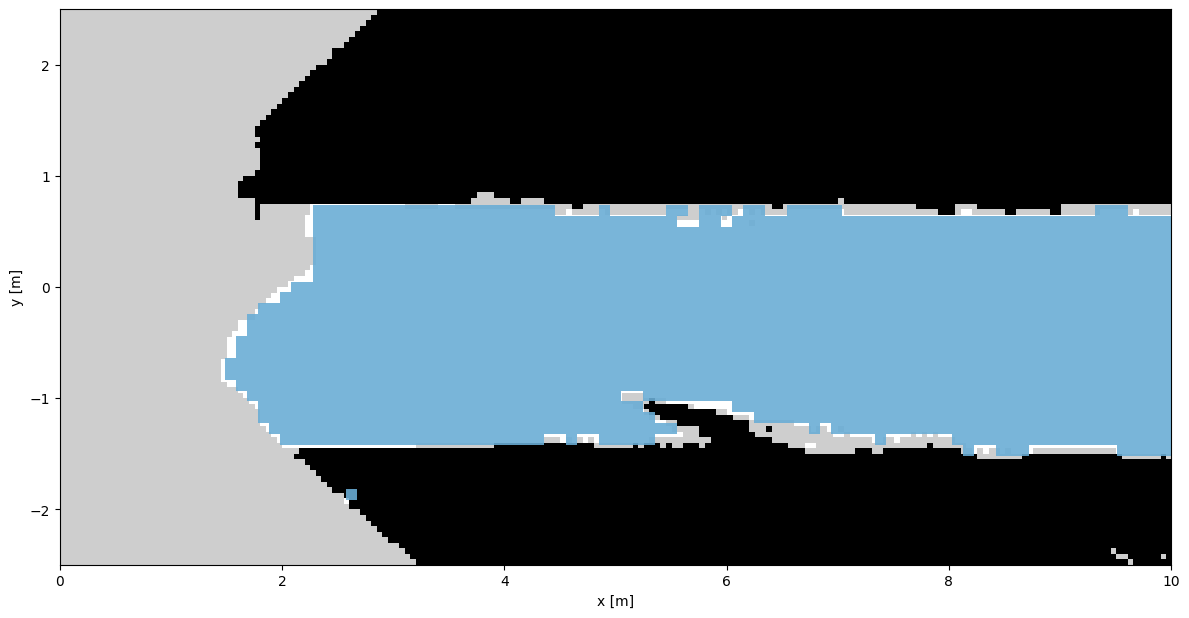

In [11]:
impl = HJImpl(reach_dynamics, grid, 1)
impl.set_axes_names('x', 'y', 'a', 'v')

out_map = Always(sidewalk_map).realize(impl)

fig = new_map(
    ('Blues', impl.project_onto(out_map[0], 0, 1, union=True)),
    min_bounds=min_bounds, max_bounds=max_bounds,
    background=BACKGROUND_PATH,
)
fig.show()

Sidewalk inflated environment realization...

100%|##########|  1.0000/1.0 [00:03<00:00,  3.71s/sim_s]
/tmp/ipykernel_23131/3412260148.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


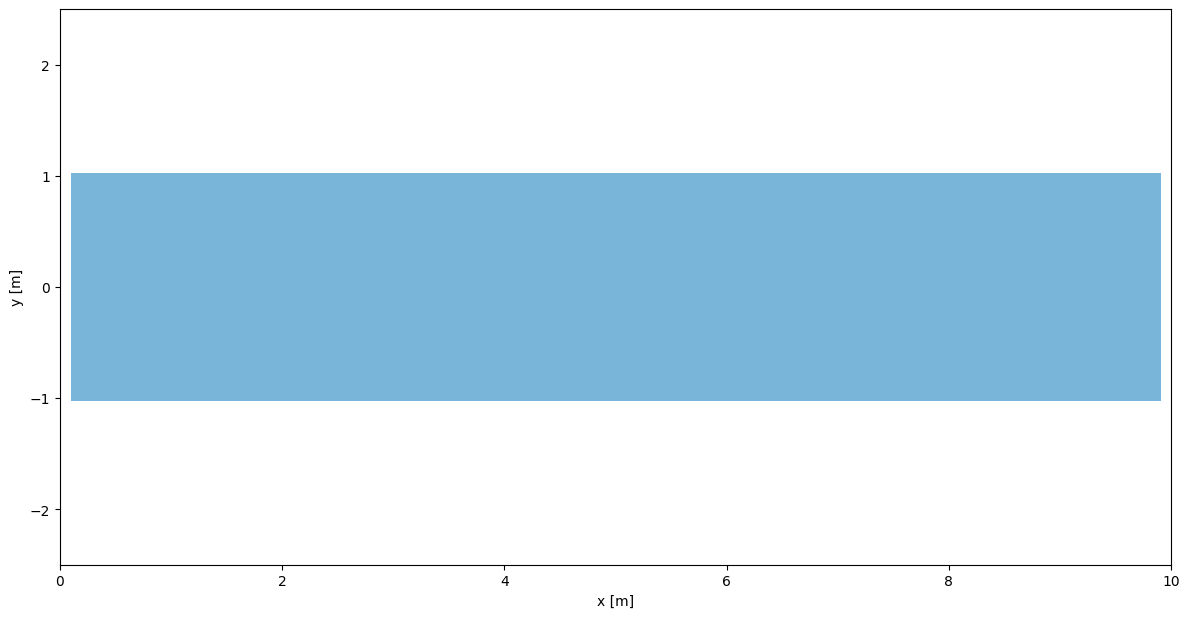

In [12]:
impl = HJImpl(reach_dynamics, grid, 1)
impl.set_axes_names('x', 'y', 'a', 'v')

out_inf = Always(sidewalk_inflated).realize(impl)

fig = new_map(
    ('Blues', impl.project_onto(out_inf[0], 0, 1, union=True)),
    min_bounds=min_bounds, max_bounds=max_bounds,
)
fig.show()

Sidewalk map inflated environment realization...

100%|##########|  1.0000/1.0 [00:04<00:00,  4.31s/sim_s]
/tmp/ipykernel_23131/3932457089.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


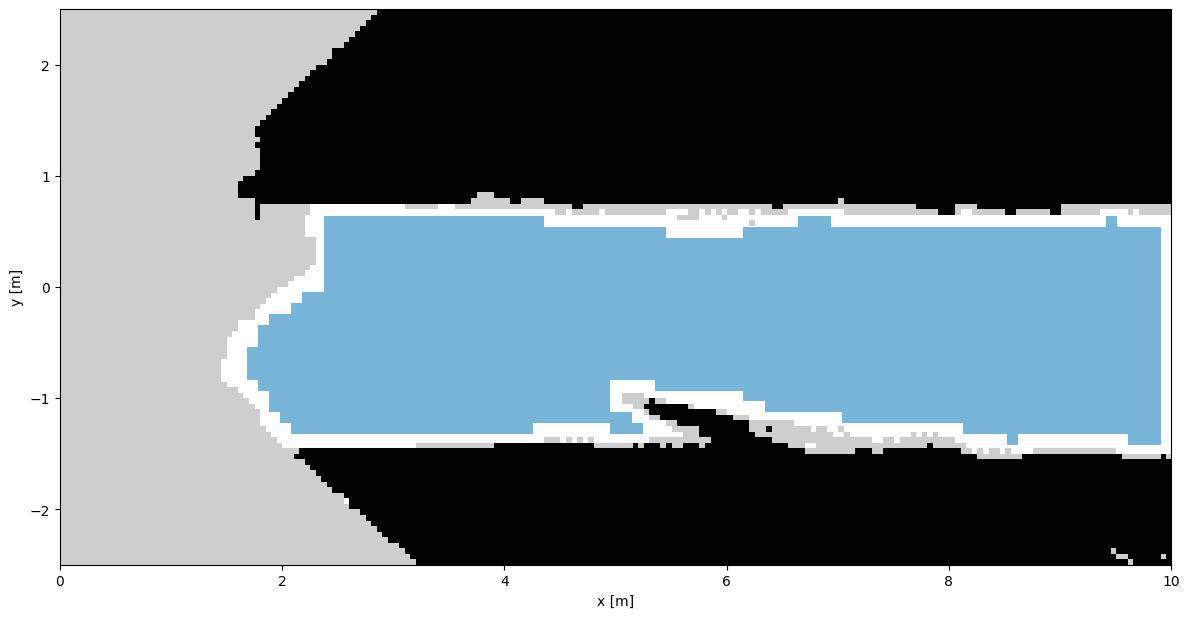

In [13]:
impl = HJImpl(reach_dynamics, grid, 1)
impl.set_axes_names('x', 'y', 'a', 'v')

out_map_inf = Always(sidewalk_map_inflated).realize(impl)

fig = new_map(
    ('Blues', impl.project_onto(out_map_inf[0], 0, 1, union=True)),
    min_bounds=min_bounds, max_bounds=max_bounds,
    background=BACKGROUND_PATH,
)
fig.show()

# 3D Visualization


In [14]:
from IPython.display import Image
from ipywidgets import interact, IntSlider
from functools import partial, wraps
import plotly.graph_objects as go
import skimage.io as sio

def new_timeline(target_time, start_time=0, time_step=0.2):
    assert time_step > 0
    is_forward = target_time >= start_time
    target_time += 1e-5 if is_forward else -1e-5
    time_step *= 1 if is_forward else -1
    return np.arange(start_time, target_time, time_step)

def interact_scenario(times, *pairs):
    fig, ax = plt.figure(), plt.gca()
    extent=[min_bounds[0], max_bounds[0],
            min_bounds[1], max_bounds[1]]
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.axis('off')
    ax.invert_yaxis()
    interaction = partial(interact, 
                        #   yaw_idx=IntSlider(0, min=0, max=grid.shape[2]-1),
                          vel_idx=IntSlider(0, min=0, max=grid.shape[4]-1),
                          time_idx=IntSlider(0, min=0, max=len(times)-1))
    def render_frame(# yaw_idx, 
                     vel_idx, 
                     time_idx):
        # print('yaw:', grid.coordinate_vectors[2][yaw_idx] * 180/np.pi)
        print('vel:', grid.coordinate_vectors[4][vel_idx])
        print('t:', times[time_idx])
        ax.clear()
        background = plt.imread(BACKGROUND_PATH)
        ax.imshow(background, extent=extent, cmap='gray')
        for cmap, vf in pairs:
            cmap = plt.get_cmap(cmap)
            if not shp.is_invariant(grid, times, vf):
                vf = vf[time_idx, :, :, :, :, vel_idx]
            vf = shp.project_onto(vf, 0, 1)
            plot_set(vf, ax=ax, alpha=0.9, cmap=cmap, extent=extent)
            # ix, iy = np.unravel_index(vf.argmin(), vf.shape)
            # x = grid.coordinate_vectors[0][ix]
            # y = grid.coordinate_vectors[1][iy]
            # a = grid.coordinate_vectors[2][yaw_idx]
            # if vf[ix, iy] <= 0:
            #     plot_arrow(ax, (x, y), a, color=cmap(0.75))
        fig.tight_layout()
        return fig
    return interaction, render_frame

def interact_tubes_time(times, *triplets, eye=None):
    background = sio.imread(BACKGROUND_PATH, as_gray=True)
    background = np.flipud(background)

    interaction = partial(interact, time_idx=IntSlider(len(times)-1, min=0, max=len(times)-1))
    def render_frame(time_idx=None):
        data = []

        meshgrid = np.mgrid[times[0]:times[-1]:complex(0, len(times)),
                            min_bounds[0]:max_bounds[0]:complex(0, grid.shape[0]), 
                            min_bounds[1]:max_bounds[1]:complex(0, grid.shape[1])]
        
        data += [
            go.Surface(
                x=np.linspace(min_bounds[0], max_bounds[0], background.shape[1]),
                y=np.linspace(min_bounds[1], max_bounds[1], background.shape[0]),
                z=times[0]*np.ones_like(background)-0.1,
                surfacecolor=background,
                colorscale='gray', 
                showscale=False,
            ),
        ]

        for triplet in triplets:

            colorscale, values = triplet[:2]
            kwargs = triplet[2] if len(triplet) == 3 else {}

            vf = shp.project_onto(values, 0, 1, 2)
            if time_idx is not None and time_idx < len(times)-1:
                vf[time_idx+1:] = 1

            data += [
                go.Isosurface(
                    x=meshgrid[1].flatten(),
                    y=meshgrid[2].flatten(),
                    z=meshgrid[0].flatten(),
                    value=vf.flatten(),
                    colorscale=colorscale,
                    showscale=False,
                    isomin=0,
                    surface_count=1,
                    isomax=0,
                    caps=dict(x_show=True, y_show=True),
                    **kwargs,
                ),
            ]
        
        fw = go.FigureWidget(data=data)
        fw.layout.update(width=720, height=720, 
                         margin=dict(l=10, r=10, t=10, b=10),
                        #  legend=dict(yanchor='bottom', xanchor='left', x=0.05, y=0.05, font=dict(size=16)),
                         scene=dict(xaxis_title='x [m]',
                                    yaxis_title='y [m]',
                                    zaxis_title='t [s]',
                                    aspectratio=dict(x=1, y=3/4, z=3/4)),
                         scene_camera=dict(eye=eye))
        fw._config = dict(toImageButtonOptions=dict(height=720, width=720, scale=6))
        return fw
    return interaction, render_frame

def interact_tubes_axis(times, *triplets, axis=2, eye=None):
    background = sio.imread(BACKGROUND_PATH, as_gray=True)
    background = np.flipud(background)

    interaction = partial(interact, time_idx=IntSlider(len(times)-1, min=0, max=len(times)-1))
    def render_frame(time_idx=None):
        data = []

        meshgrid = np.mgrid[min_bounds[0]:max_bounds[0]:complex(0, grid.shape[0]), 
                            min_bounds[1]:max_bounds[1]:complex(0, grid.shape[1]),
                            min_bounds[axis]:max_bounds[axis]:complex(0, grid.shape[axis])]
        
        data += [
            go.Surface(
                x=np.linspace(min_bounds[0], max_bounds[0], background.shape[1]),
                y=np.linspace(min_bounds[1], max_bounds[1], background.shape[0]),
                z=min_bounds[axis]*np.ones_like(background)-0.1,
                surfacecolor=background,
                colorscale='gray', 
                showscale=False,
            ),
        ]

        for triplet in triplets:

            colorscale, values = triplet[:2]
            kwargs = triplet[2] if len(triplet) == 3 else {}

            axes = 1, 2, axis+1
            vf = (shp.project_onto(values, *axes) if time_idx is None else
                  shp.project_onto(values, 0, *axes)[time_idx])

            data += [
                go.Isosurface(
                    x=meshgrid[0].flatten(),
                    y=meshgrid[1].flatten(),
                    z=meshgrid[2].flatten(),
                    value=vf.flatten(),
                    colorscale=colorscale,
                    showscale=False,
                    isomin=0,
                    surface_count=1,
                    isomax=0,
                    caps=dict(x_show=True, y_show=True),
                    **kwargs,
                ),
            ]
        
        fw = go.FigureWidget(data=data)
        fw.layout.update(width=720, height=720, 
                         margin=dict(l=10, r=10, t=10, b=10),
                        #  legend=dict(yanchor='bottom', xanchor='left', x=0.05, y=0.05, font=dict(size=16)),
                         scene=dict(xaxis_title='x [m]',
                                    yaxis_title='y [m]',
                                    zaxis_title=['Yaw [rad]', 'Delta [rad]', 'Vel [m/s]'][axis-2]),
                         scene_camera=dict(eye=eye))
        fw._config = dict(toImageButtonOptions=dict(height=720, width=720, scale=6))
        return fw
    return interaction, render_frame

def interact_tubes(*args, axis=None, **kwargs):
    return (interact_tubes_time(*args, **kwargs) if axis is None else
            interact_tubes_axis(*args, **kwargs, axis=axis))

def sphere_to_cartesian(r, theta, phi):
    theta *= np.pi/180
    phi *= np.pi/180
    return dict(x=r*np.sin(theta)*np.cos(phi),
                y=r*np.sin(theta)*np.sin(phi),
                z=r*np.cos(theta))

EYE_W   = sphere_to_cartesian(2.2, 45, -90 - 90)
EYE_WSW = sphere_to_cartesian(2.2, 70, -90 - 70)
EYE_SW  = sphere_to_cartesian(2.5, 60, -90 - 45)
EYE_SSW = sphere_to_cartesian(2.2, 70, -90 - 20)
EYE_S   = sphere_to_cartesian(2.5, 45, -90 + 0)
EYE_SSE = sphere_to_cartesian(2.2, 70, -90 + 20)
EYE_SE  = sphere_to_cartesian(2.5, 60, -90 + 45)
EYE_ESE = sphere_to_cartesian(2.2, 70, -90 + 70)
EYE_E   = sphere_to_cartesian(2.2, 45, -90 + 90)

3D inflation of the half-plane sidewalk environment

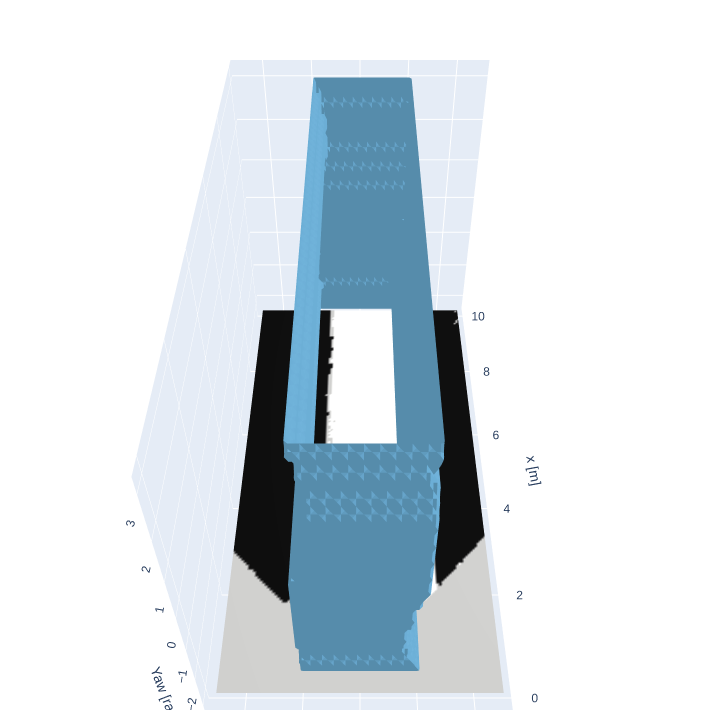

In [15]:
I, F = interact_tubes(
    impl.timeline,
    ('Blues',   out_inf, dict(opacity=1)),
    eye=EYE_W,
    axis=2
)
fig = F()
Image(fig.to_image(format='png'))

3D inflation of the sidewalk map environment

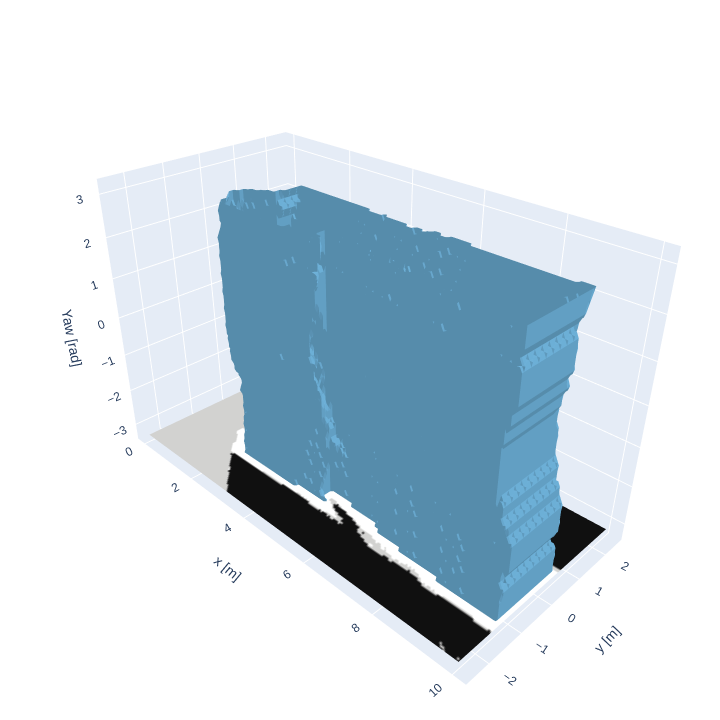

In [16]:
I, F = interact_tubes(
    impl.timeline,
    ('Blues',   out_map_inf, dict(opacity=1)),
    eye=EYE_SE,
    axis=2
)
fig = F()
Image(fig.to_image(format='png'))